# Use Prophet to Predict Revenue

In this project, I created a Python notebook for predicting financial revenue of Bank using Prophet which is a times series forecasting library pioneered by Facebook and it is idaeal for working in large datasets. 

We will used to Prophet to predict the future values of our bank revenue.

- The input for Prophet is a dataframe with two columns: date and target 9ds and y)




## Understanding the Problem Statement

Our focus is to do the technical analysis by analyzing the company’s future profitability on the basis of its current business financial performance by reading the charts and using statistical figures to identify the trends. 



## Data Sources:
* revenue_2009_2016.csv :  Processed data as an output from the data-preparation. Notebook available [here.](https://github.com/CFerraren/PyBank/blob/master/1-Data_Prep.ipynb)




### Task is to create a Python script that analyzes the records to calculate each of the following:

- Use auto Prophet which tries to capture the seasonality in the past data and works well when the dataset is large, but our dataset size is not ideal for this methodology.

- Split our data into train and validation sets to verify our predictions.


- Plot results.

### Changes:

- 02-12-2018: Started the project

- 12-11-2018: Updated the project using Python Pandas and added visualization using matplotlib, Tableau, and Univariate Linear Regression Machine learning to predict future bank revenue.


---

In [1]:
#import packages
import numpy as np
import pandas as pd
import sklearn.preprocessing as preproc
import os

#to plot within the notebook
import matplotlib.pyplot as plt
%matplotlib inline

#use seaborn to prettify the plots
import seaborn as sns
sns.set_style('whitegrid')

#display pd typeformat
pd.set_option('display.float_format', '{:,.0f}'.format)

import warnings
warnings.filterwarnings('ignore')

In [2]:
#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,5

#### Load Data

In [3]:
#directory and filename
dir = 'data/processed/'
file = 'revenue_2009_2016.csv'

In [4]:
#load csv into dataframe
data = pd.read_csv(os.path.join(dir, file), parse_dates=['Date'])

In [5]:
#make a copy
df = data.copy()

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Revenue,86,"650,527","680,460","-1,063,151","279,551","686,900","1,118,162","2,211,086"


#### Transform Data

In [7]:
#yeo-johnson transform
x = df[['Revenue']]
pt = preproc.PowerTransformer(method='yeo-johnson')
df['revenue_transformed'] = pt.fit_transform(x)

In [8]:
#Prepare and rename columns for feature and target
df.rename(columns={'revenue_transformed': 'y', 'Date': 'ds'}, inplace=True)

In [9]:
df[:5]

,ds,Revenue,y
0,2009-01-01,"943,690",0
1,2009-02-01,"1,062,565",1
2,2009-03-01,"210,079",-1
3,2009-04-01,"-735,286",-2
4,2009-05-01,"842,933",0


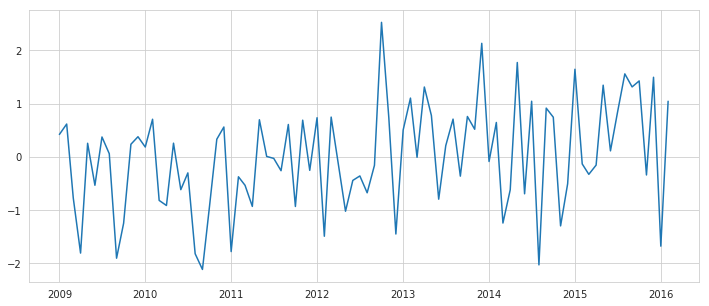

In [10]:
df_clean= df.drop(['Revenue'], axis=1)
plt.plot(df_clean['ds'],df_clean['y'])

In [11]:
#train and validation
train = df_clean[:72]
valid = df_clean[72:]

In [12]:
#importing prophet
from fbprophet import Prophet

In [13]:
#fit the model
model = Prophet()
model.fit(train)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [14]:
model.params

{'k': array([[0.2381166]]),
 'm': array([[-0.15967583]]),
 'delta': array([[-2.25062509e-09,  1.03605316e-09,  4.82245702e-09,
         -2.22676468e-09,  1.44865318e-09,  1.25161569e-09,
         -6.06968883e-10, -6.64432047e-10,  5.80207634e-11,
          5.55583606e-10,  3.14134540e-10, -1.69135143e-09,
          1.03392230e-04, -1.08669368e-10, -2.07257496e-10,
         -2.47944937e-09,  5.47302636e-10, -5.56123761e-10,
          8.15737262e-11, -4.28589632e-09, -1.50096191e-09,
          1.11510755e-09,  2.46835970e-09,  2.29788094e-09,
         -8.77541368e-09]]),
 'sigma_obs': array([[0.35404972]]),
 'beta': array([[-0.02525973,  0.09043069, -0.05669392, -0.01497314,  0.00838604,
         -0.01396588,  0.06083733,  0.00670291, -0.01540251, -0.04267389,
         -0.04072899,  0.03649934,  0.0445778 , -0.05704744, -0.02702751,
          0.02189822, -0.05829861,  0.01010657,  0.02985465,  0.04106444]])}

In [15]:
#forecast data
pred_rvn = model.make_future_dataframe(periods=len(valid))
forecast = model.predict(pred_rvn)

In [16]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [17]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][:5]

,ds,yhat,yhat_lower,yhat_upper
0,2009-01-01,-0,-1,1
1,2009-02-01,0,-1,1
2,2009-03-01,-1,-2,0
3,2009-04-01,-1,-2,0
4,2009-05-01,0,-1,1


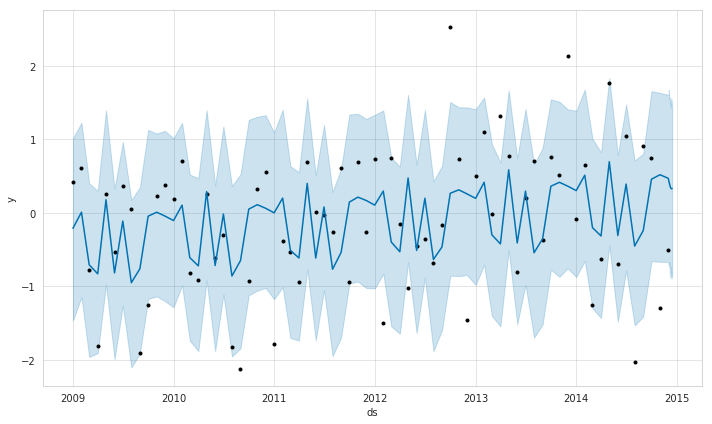

In [18]:
#prophet plotting function displaying actual values along with estimates
model.plot(forecast);

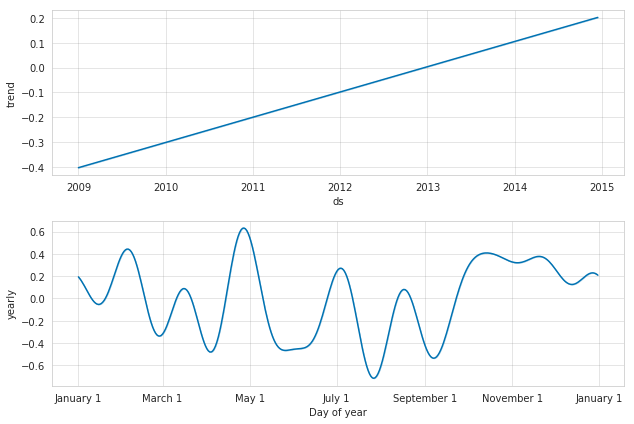

In [19]:
#visually inspect what the model is capturing
model.plot_components(forecast);

In [20]:
#rmse
forecast_valid = forecast.yhat.iloc[72:]
rms=np.sqrt(np.mean(np.power((np.array(valid['y'])-np.array(forecast_valid)),2)))
rms

0.9933335865548958

In [21]:
#mean absolute error
from sklearn.metrics import mean_absolute_error
pred = model.predict(valid)
mean_absolute_error(np.exp(valid['y']), np.exp(pred['yhat']))

1.6363509105126426

In [22]:
#show the validation results
valid['Predictions'] = forecast_valid.values

In [23]:
#set to orginal scaling of revenues
train['Revenue'] = pt.inverse_transform(train[['y']])
valid['y_scale'] = pt.inverse_transform(valid[['y']])
valid['predict_scale'] = pt.inverse_transform(valid[['Predictions']])

In [24]:
valid[:5]

,ds,y,Predictions,y_scale,predict_scale
72,2015-01-01,2,0,"1,683,373","963,843"
73,2015-02-01,-0,0,"605,485","953,242"
74,2015-03-01,-0,0,"485,584","942,765"
75,2015-04-01,-0,0,"592,122","932,646"
76,2015-05-01,1,0,"1,503,562","923,112"


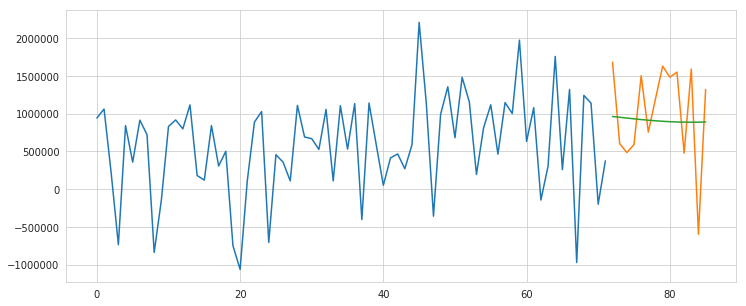

In [25]:
#plot on orignal scaling of revenues
plt.plot(train['Revenue'])
plt.plot(valid[['y_scale', 'predict_scale']])